In [ ]:
!pip install wget
!pip install awscli
import os
os._exit(00)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=04ade7db4a7a461d04357793ce84503034cc9ad35975fb04734967951cee11d6
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.9 MB 5.3 MB/s 
     |████████████████████████████████| 548 kB 51.2 MB/s 
     |████████████████████████████████| 9.1 MB 35.8 MB/s 
     |████████████████████████████████| 636 kB 60.7 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 140 kB 52.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: 

In [1]:
!export AWS_SHARED_CREDENTIALS_FILE=/content/drive/MyDrive/config/awscli.ini
path="/content/drive/MyDrive/config/awscli.ini"

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

import pandas as pd
import wget
import numpy as np
import json
import os
import pickle
import yaml
import shutil

os.environ['AWS_SHARED_CREDENTIALS_FILE']=path
import awscli

import matplotlib.pyplot as plt

import tensorflow as tf

import warnings; warnings.simplefilter('ignore')

from drive.MyDrive.mushroom_classification import inat_src
from drive.MyDrive.mushroom_classification.src import tfrecord_functions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
CFG = yaml.safe_load(open('drive/MyDrive/mushroom_classification/new/src/config.YAML', 'rb'))

# Downloading Data

In [4]:
import tarfile
!aws s3 cp s3://ml-inat-competition-datasets/2021/train_mini.tar.gz .
!aws s3 cp s3://ml-inat-competition-datasets/2021/val.tar.gz .
!aws s3 cp s3://ml-inat-competition-datasets/2021/val.json.tar.gz .
!aws s3 cp s3://ml-inat-competition-datasets/2021/train_mini.json.tar.gz .

with tarfile.open('train_mini.tar.gz') as f:
    f.extractall()
with tarfile.open('val.tar.gz') as f:
    f.extractall()
with tarfile.open('val.json.tar.gz') as f:
    f.extractall()
with tarfile.open('train_mini.json.tar.gz') as f:
    f.extractall()

download: s3://ml-inat-competition-datasets/2021/train_mini.tar.gz to ./train_mini.tar.gz
download: s3://ml-inat-competition-datasets/2021/val.tar.gz to ./val.tar.gz
download: s3://ml-inat-competition-datasets/2021/val.json.tar.gz to ./val.json.tar.gz
download: s3://ml-inat-competition-datasets/2021/train_mini.json.tar.gz to ./train_mini.json.tar.gz


In [ ]:
val = src.read_aws_jsons('val.json')
train_mini = src.read_aws_jsons('train_mini.json')

remove_images_not_fungi('val', val)
remove_images_not_fungi('train_mini', train_mini)

train_mini, val = create_labels(train_mini, val)
train_mini, val = create_filepaths(train_mini, val)

In [ ]:
train_mini['gcs_filepath'] = 'gs://mushy_class/' + train_mini['filepath']
val['gcs_filepath'] = 'gs://mushy_class/' + val['filepath']

# Writing Records

In [ ]:
rootdir = 'content'
tfrecords_dir = 'tfrecords'

train_dir = 'train_mini'
train_dir = os.path.join(rootdir, train_dir)

val_dir = 'val'
val_dir = os.path.join(rootdir, val_dir)

train_samples_per_record = 1024
train_num_records = train_mini.shape[0] // train_samples_per_record

val_samples_per_record = 256
val_num_records = val.shape[0] // val_samples_per_record

if train_mini.shape[0] % train_samples_per_record:
    train_num_records += 1
if val.shape[0] % val_samples_per_record:
    val_num_records += 1
if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)

In [ ]:
for record_num in range(train_num_records):
    samples = train_mini.iloc[(record_num * train_samples_per_record) : ((record_num + 1) * train_samples_per_record)]
    
    with tf.io.TFRecordWriter(
        tfrecords_dir + f'/{record_num}_inat_train_{len(samples)}.tfrec'
    ) as writer:

        for idx, row in samples.iterrows():           
            img_path = row['filepath']
            image = tf.io.decode_jpeg(tf.io.read_file(img_path))
            example = tfrecord_functions.create_example(image, img_path, row)
            # print(example)
            writer.write(example.SerializeToString())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
raw_dataset = tf.data.TFRecordDataset(f"tfrecords/1_inat_train_1024.tfrec")
parsed_dataset = raw_dataset.map(tfrecord_functions.parse_tfrecord_fn)
for features in parsed_dataset.take(10):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for record_num in range(val_num_records):
    samples = val.iloc[(record_num * val_samples_per_record) : ((record_num + 1) * val_samples_per_record)]
    
    with tf.io.TFRecordWriter(
        tfrecords_dir + f'/val/{record_num}_inat_val_{len(samples)}.tfrec'
    ) as writer:

        for idx, row in samples.iterrows():           
            img_path = row['filepath']
            image = tf.io.decode_jpeg(tf.io.read_file(img_path))
            example = tfrecord_functions.create_example(image, img_path, row)
            #print(example)
            writer.write(example.SerializeToString())

category_id: 65
path: b'val/05429_Lobaria_anthraspis/32c2e46e-1bc1-47ef-b4ff-85c8211ec37e.jpg'
Image shape: (500, 375, 3)


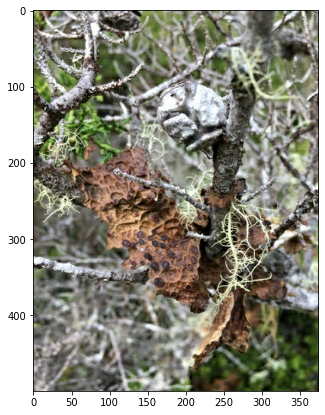

In [ ]:
raw_dataset = tf.data.TFRecordDataset(f"tfrecords/1_inat_val_256.tfrec")
parsed_dataset = raw_dataset.map(tfrecord_functions.parse_tfrecord_fn)
for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

In [ ]:
!ls -l tfrecords

total 2029792
-rw-r--r-- 1 root root 100729420 Aug 27 10:02 0_inat_train_1024.tfrec
-rw-r--r-- 1 root root  25712833 Aug 27 10:51 0_inat_val_256.tfrec
-rw-r--r-- 1 root root 107736626 Aug 27 10:04 10_inat_train_1024.tfrec
-rw-r--r-- 1 root root  26959024 Aug 27 10:51 10_inat_val_256.tfrec
-rw-r--r-- 1 root root 107395808 Aug 27 10:04 11_inat_train_1024.tfrec
-rw-r--r-- 1 root root  26695179 Aug 27 10:51 11_inat_val_256.tfrec
-rw-r--r-- 1 root root 106962992 Aug 27 10:04 12_inat_train_1024.tfrec
-rw-r--r-- 1 root root  25575103 Aug 27 10:51 12_inat_val_256.tfrec
-rw-r--r-- 1 root root 106959710 Aug 27 10:05 13_inat_train_1024.tfrec
-rw-r--r-- 1 root root   8204692 Aug 27 10:51 13_inat_val_82.tfrec
-rw-r--r-- 1 root root 108166144 Aug 27 10:05 14_inat_train_1024.tfrec
-rw-r--r-- 1 root root 103011968 Aug 27 10:05 15_inat_train_1024.tfrec
-rw-r--r-- 1 root root  64587059 Aug 27 10:05 16_inat_train_666.tfrec
-rw-r--r-- 1 root root 100891511 Aug 27 10:02 1_inat_train_1024.tfrec
-rw-r--r-- 1

In [ ]:
!gsutil -m cp -r /content/tfrecords gs://mushy_class

Copying file:///content/tfrecords/train/8_inat_train_1024.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/train/2_inat_train_1024.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/train/5_inat_train_1024.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/train/16_inat_train_666.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/train/3_inat_train_1024.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/train/14_inat_train_1024.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/train/13_inat_train_1024.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/train/9_inat_train_1024.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/train/1_inat_train_1024.tfrec [Content-Type=application/octet-stream]...
Copying file:///content/tfrecords/t